# Introduction 
The Transformer from ["Attention is All You Need"](https://arxiv.org/abs/1706.03762) is a groundbreaking neural network architecture that quickly became a new standard for NLP. Besides producing major improvements in translation quality, it paved the way for a new family of related architectures used for many other NLP tasks. For example, for language modeling, architectures based on the Transformer were used to generate [impressively realistic random pieces of text](https://openai.com/blog/better-language-models/). In this practical we will review an "annotated" version of the paper in the form of a line-by-line implementation. Sections from the original paper were quoted directly and comments were added throughout. 

Once we introduce the architecture and understand the self-attention mechanism, we will use them for a machine translation application using the original Transformer architecture. If you want to explore further, we have prepared an [extra notebook](https://github.com/khipu-ai/practicals-2019/blob/master/2b_nlp_transformer_extra.ipynb) adapting the code viewed here for a Language Modeling task using a model similar to 
OpenAI's famous [GPT-2](https://openai.com/blog/better-language-models/), which actually requires only minor modifications to the Transformer.

This notebook is a bit long so we recommend using the table of contents on the left for a better browsing experience.


## Disclaimer

This notebook was adapted with permission from [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html) by Alexander Rush. 
The original post presents a line-by-line implementation of the paper, with some additional comments. We have adapted and expanded some of Rush's comments, but for others we are quoting them directly with a "**Rush**" tag in front.

The code is based heavily on [OpenNMT](http://opennmt.net) packages.
For other full-sevice implementations of the model check-out [Tensor2Tensor](https://github.com/tensorflow/tensor2tensor) (tensorflow), [Sockeye](https://github.com/awslabs/sockeye) (mxnet) and the [Hugging Face library](https://github.com/huggingface/transformers) (torch and tensorflow).

Even thought this follows the order of the paper, we recommend you do a quick read before you start to get a general sense of what is going to happen.

Adaptated for [Khipu](https://khipu.ai) by Diego de Las Casas, Roberto de Moura, José Lezama and Igor Quintanilha.

# Background

## Sequence-to-Sequence Modeling

The Transformer is a neural architecture used for Sequence-to-Sequence modeling. These architectures model functions that transform an input sequence into an output sequence, both of arbitrary length. (Another architecture of this family you may be familiar with are recurrent neural networks.) In the Transformer, a feature vector representation is obtained for each element of the sequences (e.g. each word in NLP), via parameterized transformations. Central to the Transformer is a transformation based on the **self-attention** concept, which we will explore later in this notebook. Finally, these representations are used to compute the probability of the next element in the output sequence. Namely, if $x^i$ and $x^o$ are the input and output sequences of $n_i$ and $n_o$ elements respectively, the Transformer models the probability of the next output element considering the entire input sequence and all the output elements predicted so far:
$$P(x^o_j | x^i_1\ldots x^i_{n_i}, x^o_1\ldots x^o_{j-1}) ~~~~~~\text{for } j=1\ldots n_o$$  

As we shall see, one important advantage of the Transformer is that it is able to compute these probabilities for all output elements in parallel, achieving improved computational efficiency compared to recurrent neural networks.

## Overview
A Transformer architecture is divided into an Encoder and a Decoder part. As we mentioned, the Transformer uses parameterized transformations to obtain vector representations of each word. The Encoder part computes the representation of the input sequence, and the generates the output sequence. One of the parameterized transformations used in the Transformer is based on the **attention** mechanism, which expresses the dependency of one word with the other words in the sequence. We will explain this in detail later, but for now you can see the effect of attention in the animation below (from [Google's blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)). Observe how the representation of each word in a sequence depends on the other words. We call *encoding* the process of finding the representations of the input words or tokens, and *decoding* those of the output words. Notice that for the output words, they can only "attend to" previous words that have already been determined.


![modalnet](https://3.bp.blogspot.com/-aZ3zvPiCoXM/WaiKQO7KRnI/AAAAAAAAB_8/7a1CYjp40nUg4lKpW7covGZJQAySxlg8QCLcBGAs/s640/transform20fps.gif)

The self-attention mechanism uses matrix-vector products and a softmax non-linearity. The other parameterized operations in the Transformer are simple fully-connected layers that are applied to each token, and word embeddings applied at the input and output (a word embedding transforms a one-hot word representation into a lower-dimensional feature vector or viceversa). Inside the Encoder or Decoder, the same transformations are applied to each word. This allows treatment of sequence of varying length! These matrix-vector operations contain all the learnable parameters in the Transformer. Transformers also use other familiar deep learning operations such as residual connections, Dropout and normalization.

The following figure from [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/), a great blog post explaining the architecture, gives another overview. Note that the Encoder and Decoder are made up of multiple similar layers.

<center>
<img src="http://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png" width=680px>
</center>


We are now ready to delve deeper into the Transformer by following the original article. Don't worry if these ideas are not yet clear in your head we will go thorugh each step in detail.




# Setup

In [0]:
#@title Prelims: Load Libraries (they're all pre-installed in colab)
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

# Model Architecture

> Most competitive neural sequence transduction models have an [encoder-decoder structure](https://arxiv.org/abs/1409.0473). Here, the encoder maps an input sequence of symbol representations $(x_1, ..., x_n)$ to a sequence of continuous representations $\mathbf{z} = (z_1, ..., z_n)$. Given $\mathbf{z}$, the decoder then generates an output sequence $(y_1,...,y_m)$ of symbols one element at a time. At each step the model is [auto-regressive](https://arxiv.org/abs/1308.0850), consuming the previously generated symbols as additional input when generating the next.


An autoregressive encoder-decoder architecture will look something like this, given a `sequence` input:
```python
# sequence = sequence[:t]  <- optional slicing for predicting from time t
code = encoder(sequence)
output = []
for i in range(prediction_length):
  output[i] = decoder(code, output[:i])
```


Here is how an `EncoderDecoder` architecture can be implemented.
The implementation has a couple of extra tweaks:
- We'll need to pass in some additional information to implement masking (for example, to prevent the decoder from looking into next words). More on that later.
- We separate the `decoder` step into `decoder` and `generator` functions. The `decoder` function will generate the feature representation and the `generator` will compute the probabilities of the corresponding token. This is not needed, but in general good practice because it allows you to access intermediate representations of the network.

In [0]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

The `Generator` projects the feature representation into the space of possible words and computes the softmax to model their probabilities. 

In [0]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

> The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1, respectively. 


Here is Figure 1 from the original paper.

<center> 
  <img src="https://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png">
</center>


## Encoder and Decoder Stacks   

Let's unpack what is within the encoder and decoders.

### Encoder

> The encoder is composed of a stack of $N=6$ identical layers. 

In [0]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [0]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

> We employ a [residual connection](https://arxiv.org/abs/1512.03385) around each of the two sub-layers, followed by [layer normalization](https://arxiv.org/abs/1607.06450).  

In [0]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See link for details)."
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

> That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.  We apply [dropout](http://jmlr.org/papers/v15/srivastava14a.html) to the output of each sub-layer, before it is added to the sub-layer input and normalized.  
> 
> To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.  

In [0]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):   
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

> Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [0]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder

> The decoder is also composed of a stack of $N=6$ identical layers.  


In [0]:
class Decoder(nn.Module):
    "Generic N layer sequential decoder with masking."
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

> In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack.  Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.  

In [0]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

> We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions.  This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.

In [0]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    return torch.tril(torch.ones(1, size, size, dtype=torch.bool))

This is how a mask will look like: For time  $t$, the network will pick the mask of the $t$th row. All values above $t$ will have been masked out.

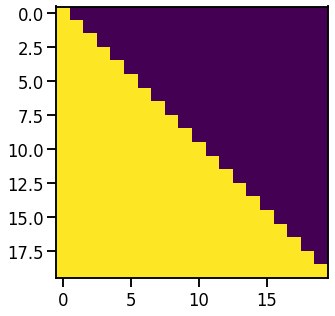

In [27]:
plt.figure(figsize=(5,5))
_ = plt.imshow(subsequent_mask(20)[0])

### Attention                                                                                                                                                                                                                                                                          
> An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.                 
>
> We call our particular attention "Scaled Dot-Product Attention".   The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$.  We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.                                                                                                                                                                                                                                  
                                                                                                                                                                     

<center> 
  <img src="http://nlp.seas.harvard.edu/images/the-annotated-transformer_33_0.png">
</center>

> In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:                                                                      
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$   

#### Task: Can you implement the attention function with this definition?

**Hint**: The dropout (an optional callable) is applied after the soft-max function

In [0]:
def attention(query, key, value, mask=None, dropout=None):
  "Compute 'Scaled Dot Product Attention'"
  pass

#### Answer

In [0]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.shape[-1]
    scores = torch.matmul(
        query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(~mask, float('-inf'))
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

#### Optional reading: dot-product vs. additive attention


> The two most commonly used attention functions are [additive attention](https://arxiv.org/abs/1409.0473), and dot-product (multiplicative) attention.  Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer.  While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.
>                                                                         
> While for small values of $d_k$ the two mechanisms perform similarly, [additive attention outperforms dot product attention without scaling for larger values of $d_k$](https://arxiv.org/abs/1703.03906). We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients  (To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean $0$ and variance $1$.  Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance $d_k$.). To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.          

### Multi-head Attention

<center> 
  <img src="http://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png" width=20%>
</center>

> Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.                                            
$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$                                                                                                                 
>
> Where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.                                                                                                                                                                                             In this work we employ $h=8$ parallel attention layers, or heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality. 

#### Now try implementing the multi-head attention module using the `attention` function and the formulas above.


In [0]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super().__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        # 1) Do all the linear projections  from d_model => h x d_k 

        # 2) Apply attention on all the projected vectors 
        
        # 3) "Concat" and apply a final linear. 
        
        
        pass

#### Answer

In [0]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super().__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.shape[0]
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### Putting it all together
This figure from [Lilian Weng's blog](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)  shows how the attention heads are finally combined in the model. 

<center>
<img src="https://camo.githubusercontent.com/4b80977ac0757d1d18eb7be4d0238e92673bfaba/68747470733a2f2f6c696c69616e77656e672e6769746875622e696f2f6c696c2d6c6f672f6173736574732f696d616765732f7472616e73666f726d65722e706e67" width=680px>
</center>

### Applications of Attention in our Model                                                                                                                                                      
> The Transformer uses multi-head attention in three different ways:                                                   
>
> 1) In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder.   This allows every position in the decoder to attend over all positions in the input sequence.  This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as [Google's Neural Machine Translation System](https://arxiv.org/abs/1609.08144).    
>
> 2) The encoder contains self-attention layers.  In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder.   Each position in the encoder can attend to all positions in the previous layer of the encoder.                                                   
>
> 3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position.  We need to prevent leftward information flow in the decoder to preserve the auto-regressive property.  We implement this inside of scaled dot-product attention by masking out (setting to $-\infty$) all values in the input of the softmax which correspond to illegal connections.                                                                                                                  

## Position-wise Feed-Forward Networks                                                                                                                                                                                          
> In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically.  This consists of two linear transformations with a ReLU activation in between.
>
> $$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$
>
> While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1.  The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has dimensionality $d_{ff}=2048$. A dropout is applied after the ReLU activation.

In [0]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings and Softmax                                                                                                                                                                 
> Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{\text{model}}$.  We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities.  In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [(cite)](https://arxiv.org/abs/1608.05859). In the embedding layers, we multiply those weights by $\sqrt{d_{\text{model}}}$.                                                                                                                                 

In [0]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding                                                                                                                             
> Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.  To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.  The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.   There are [many choices](https://arxiv.org/pdf/1705.03122.pdf) of positional encodings, learned and fixed. 
> 
> In this work, we use sine and cosine functions of different frequencies:                                             
>
>$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$
>
>$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$  
> 
> where $pos$ is the position and $i$ is the dimension.  That is, each dimension of the positional encoding corresponds to a sinusoid.  The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.  We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$. 
>
>In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.  For the base model, we use a rate of $P_{drop}=0.1$. 
                                                                                                                                                                                                                                                    


In [0]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.shape[1]]
        return self.dropout(x)

You can see below how positional encoding will change with time (x axis), along
different dimensions (colors).The frequency and offset of the waves will be different per dimension.


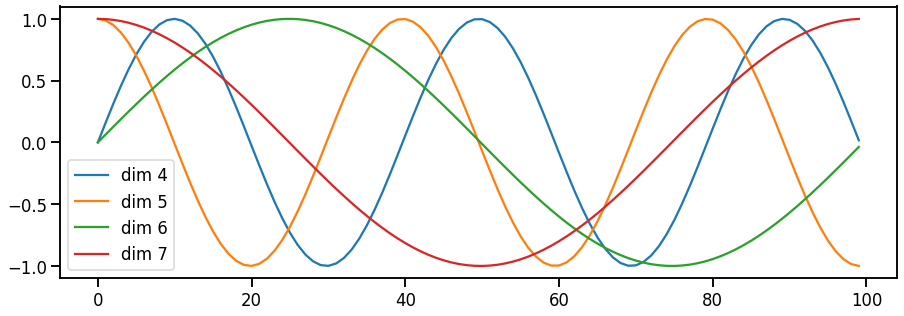

In [35]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].numpy())
_ = plt.legend(["dim %d"%p for p in [4,5,6,7]])

> We also experimented with using [learned positional embeddings](https://arxiv.org/pdf/1705.03122.pdf) instead, and found that the two versions produced nearly identical results.  We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.    

## Full Model

> Here we define a function from hyperparameters to a full model. 

In [0]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(
            d_model, c(attn), c(attn), c(ff), dropout), N),
        src_embed=nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        tgt_embed=nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)), 
        generator=Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [0]:
# Small example model.
tmp_model = make_model(10, 10, 2)

# Training

> This section describes the training regime for our models.

We stop for a quick interlude to introduce some of the tools 
needed to train a standard Encoder-Decoder model. First we define a batch object that holds the src and target sentences for training, as well as constructing the masks. 

First we create a generic training and scoring loop. The loss is a simple callback that gets the predictions, targets and some regularization data. It *may* get a reference to the optimizer, which can do the parameter updates. For the moment we will use a handler for the loss function, that will be defined below.

In [0]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens.float())
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [0]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(
            x.contiguous().view(-1, x.size(-1)), 
            y.contiguous().view(-1)) 
        loss /= norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

## Batches and Masking

In [0]:
def make_std_mask(tgt, pad):
    "Create a mask to hide padding and future words."
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & subsequent_mask(tgt.shape[-1]).type_as(tgt_mask)
    return tgt_mask

class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).sum()

## Training Data and Batching

> **Paper:** We trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs.  Sentences were encoded using byte-pair encoding, which has a shared source-target vocabulary of about 37000 tokens. For English-French, we used the significantly larger WMT 2014 English-French dataset consisting of 36M sentences and split tokens into a 32000 word-piece vocabulary.
>
> Sentence pairs were batched together by approximate sequence length.  Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens.     

> **Rush**: We will use torch text for batching. This is discussed in more detail below. Here we create batches in a torchtext function that ensures our batch size padded to the maximum batchsize does not surpass a threshold (25000 if we have 8 gpus).

In [0]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

## Hardware and Schedule                                                                                                                                                                                                   
> We trained our models on one machine with 8 NVIDIA P100 GPUs.  For our base models using the hyperparameters described throughout the paper, each training step took about 0.4 seconds.  We trained the base models for a total of 100,000 steps or 12 hours. For our big models, step time was 1.0 seconds.  The big models were trained for 300,000 steps (3.5 days).

## Optimizer

> We used the [Adam optimizer](https://arxiv.org/abs/1412.6980) with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$.  We varied the learning rate over the course of training, according to the formula:                                                                                            
$$                                                                                                                                                                         
lrate = d_{\text{model}}^{-0.5} \cdot                                                                       \min({step\_num}^{-0.5},                                                                                   {step\_num} \cdot {warmup\_steps}^{-1.5})                                                             $$                                                                                                                                                                                             
This corresponds to increasing the learning rate linearly for the first $warmup\_steps$ training steps, and decreasing it thereafter proportionally to the inverse square root of the step number.  We used $warmup\_steps=4000$.                            

This part is very important, and vital for successfully training the network. It is different than standard learning rate annealing, which only decreases the rate as training progresses. Here, the learning rate starts low, then *increases*, then linearly decreases.
This is sometimes called *warmup*, and was employed, e.g., in the [the original ResNet paper](https://arxiv.org/pdf/1512.03385.pdf). See also [these](https://arxiv.org/pdf/1706.02677.pdf) [two](https://arxiv.org/pdf/1904.00962.pdf) papers showing the effect of warmup in large minibatches.


In [0]:
class VaryingRateOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

We can see how the learning rate changes with training. 

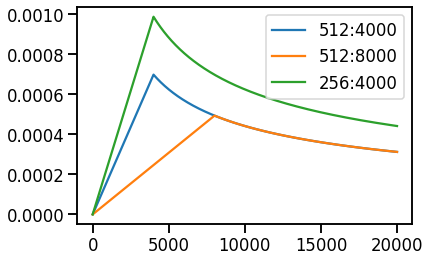

In [43]:
# Three settings of the lrate hyperparameters.
opts = [VaryingRateOpt(512, 1, 4000, None), 
        VaryingRateOpt(512, 1, 8000, None),
        VaryingRateOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
_ = plt.legend(["512:4000", "512:8000", "256:4000"])

## Regularization and Loss Function
Here is where we define the loss function for training the Transformer. In this case, we would like to compare the probability distribution of the next word, as predicted by the model, with the true distribution. When we have a ground truth label for the next word the probability distribution would be obtained by assigning all the probability mass to that word. To smooth this distribution, we will apply label smoothing, which consists in distributing a little of that probability mass to all the other words in the vocabulary.

Finally, the model's predicted distribution ($p_\theta$) and the smoothed ground truth distribution ($p_{smoothing}$)will be compared using the Kullback-Leibler divergence.

$loss = KL\left(p_\theta(\text{next word}) \mid\mid p_{\text{smoothing}}(\text{next word})\right) $

### Label Smoothing

> During training, we employed [label smoothing of value $\epsilon_{ls}=0.1$](https://arxiv.org/abs/1512.00567).  This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.  

In [0]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super().__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing # probability mass assigned to the true word
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.shape[1] == self.size
        true_dist = x.detach().clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist)

> **Rush**: Here we can see an example of how the mass is distributed to the words based on confidence. 

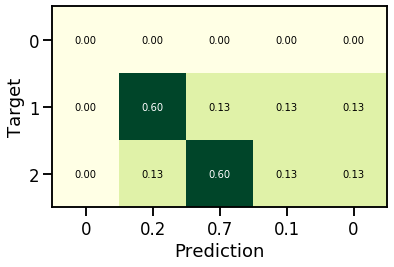

In [45]:
#Example of label smoothing.
target = [2, 1, 0]
prediction = [0, 0.2, 0.7, 0.1, 0]
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.tensor([prediction]*3)
v = crit(predict.log(), 
         torch.tensor(target))

# This will show the smoothed value given a prediction and a target:
plt.imshow(crit.true_dist, cmap='YlGn')
plt.xlabel('Prediction'); plt.xticks(np.arange(len(prediction)), prediction)
plt.ylabel('Target'); plt.yticks(np.arange(len(target)), target)
for j in range(5):
  for i in range(3):
    plt.text(j,i, '{:.2f}'.format(crit.true_dist[i, j]),
             ha="center", va="center",
             color="black" if crit.true_dist[i, j] < .5 else "white")
plt.ylim((-0.5, 2.5))
plt.show()

> **Rush**: Label smoothing actually starts to penalize the model if it gets very confident about a given choice. 

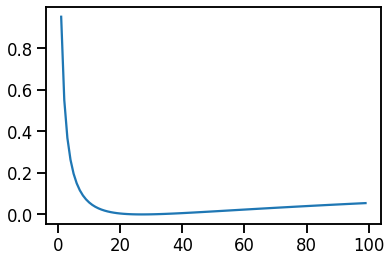

In [46]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = float(x + 3 * 1)
    predict = torch.tensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(predict.log(),
                torch.tensor([1])).item()
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
plt.show()

# Application 1: Sequence-to-Sequence Translation

In this section we will train a Transformer to do Machine Translation. If you are interested in realistic random text generation, please make sure to check our [extra notebook on Language Modeling](https://github.com/khipu-ai/practicals-2019/blob/master/2b_nlp_transformer_extra.ipynb).

## A first example with synthetic Data 

> **Rush**: We can begin by trying out a simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols. 

In [0]:
def data_gen(vocab_size, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.randint(1, vocab_size, size=(batch, 10), device='cuda')
        data[:, 0] = 1
        src = data.clone()
        tgt = data.clone()
        yield Batch(src, tgt, 0)

In [48]:
batch = next(iter(data_gen(5, 1, 1)))
print('src:', batch.src)
print('trg:', batch.trg)

src: tensor([[1, 3, 1, 4, 3, 4, 3, 4, 3, 3]], device='cuda:0')
trg: tensor([[1, 3, 1, 4, 3, 4, 3, 4, 3]], device='cuda:0')


### Greedy Decoding 


In [49]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2).cuda()
model_opt = VaryingRateOpt(
    model_size=model.src_embed[0].d_model, factor=1, warmup=400, 
    optimizer=torch.optim.Adam(
        model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

train_op = SimpleLossCompute(model.generator, criterion, model_opt)
eval_loss = SimpleLossCompute(model.generator, criterion, None)
for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, train_op)
    print(train_op.opt.rate())
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, eval_loss))

Epoch Step: 1 Loss: 2.845400 Tokens per Sec: 4334.990723
0.00011048543456039807
Epoch Step: 1 Loss: 1.882589 Tokens per Sec: 16374.405273
tensor(1.8947, device='cuda:0')
Epoch Step: 1 Loss: 1.978946 Tokens per Sec: 9701.924805
0.00022097086912079613
Epoch Step: 1 Loss: 1.640284 Tokens per Sec: 13767.615234
tensor(1.6317, device='cuda:0')
Epoch Step: 1 Loss: 1.728605 Tokens per Sec: 9690.593750
0.00033145630368119417
Epoch Step: 1 Loss: 1.341952 Tokens per Sec: 16143.436523
tensor(1.3341, device='cuda:0')
Epoch Step: 1 Loss: 1.565369 Tokens per Sec: 9516.888672
0.00044194173824159226
Epoch Step: 1 Loss: 1.215601 Tokens per Sec: 15877.379883
tensor(1.2295, device='cuda:0')
Epoch Step: 1 Loss: 1.320554 Tokens per Sec: 9455.898438
0.0005524271728019904
Epoch Step: 1 Loss: 0.947675 Tokens per Sec: 14929.497070
tensor(0.9646, device='cuda:0')
Epoch Step: 1 Loss: 1.089087 Tokens per Sec: 9542.026367
0.0006629126073623883
Epoch Step: 1 Loss: 0.632629 Tokens per Sec: 12543.053711
tensor(0.6554,

For simplicity, we will use **greedy decoding**. This means we will always pick the word with highest probability as the next word to geneate a sentence.

In [0]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    code = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src)
    mask = subsequent_mask(ys.shape[1]).to(src.device)
    for i in range(max_len-1):
        out = model.decode(
            memory=code, src_mask=src_mask, tgt=ys, tgt_mask=mask)
        prob = model.generator(out[:, -1])
        # Just pick the word with the highest probability
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word[0]
        ys = torch.cat(
            [ys, torch.ones(1, 1).type_as(src).fill_(next_word)], dim=1)
    return ys

In [51]:
model.eval()
src = torch.tensor([[1,2,3,4,5,6,7,8,9,10]]).to('cuda')
src_mask = torch.ones(1, 1, 10, dtype=torch.bool).to('cuda')
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]], device='cuda:0')


## A Real World Translation Example

> Now we consider a real-world example using the IWSLT German-English Translation task. This task is much smaller than the WMT task considered in the paper, but it illustrates the whole system. We also show how to use multi-gpu processing to make it really fast.

In [52]:
!pip install torchtext spacy==2.0.10
!python -m spacy download en
!python -m spacy download de

     |████████████████████████████████| 17.5MB 2.7MB/s 
     |████████████████████████████████| 81kB 11.8MB/s 
     |████████████████████████████████| 1.2MB 53.8MB/s 
     |████████████████████████████████| 890kB 22.2MB/s 
     |████████████████████████████████| 194kB 60.8MB/s 
     |████████████████████████████████| 153kB 55.5MB/s 
     |████████████████████████████████| 604kB 52.2MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 450kB 66.2MB/s 
  Created wheel for spacy: filename=spacy-2.0.10-cp36-cp36m-linux_x86_64.whl size=24351363 sha256=5f9a99d6e4a5dd57d92007f0576a476e43e0fd4457cf7c9c3bfdde8245dff41e
  Stored in directory: /root/.cache/pip/wheels/0b/8c/77/1cff21364a6e89e93e60a0407072cb28042bc092d2cc48dc35
  Created wheel for thinc: filename=thinc-6.10.3-cp36-cp36m-linux_x86_64.whl size=4120147 sha256=3b39ed87693297ddd7d846cca948a18ea35ed7a34e56900fc1cab0390d213f61
  Stored in directory: /root/.cache/pip/wheels/db/bc/e1/9b321b6b203

### Data Loading 
> We will load the dataset using torchtext and spacy for tokenization. 

In [53]:
# For data loading.
from torchtext import data, datasets

import spacy
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                  eos_token = EOS_WORD, pad_token=BLANK_WORD)

MAX_LEN = 100
train, val, test = datasets.IWSLT.splits(
    exts=('.de', '.en'), fields=(SRC, TGT), 
    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
        len(vars(x)['trg']) <= MAX_LEN)
MIN_FREQ = 2
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

downloading de-en.tgz


de-en.tgz: 100%|██████████| 24.2M/24.2M [00:08<00:00, 2.80MB/s]


.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.de.xml
.data/iwslt/de-en/train.tags.de-en.de
.data/iwslt/de-en/train.tags.de-en.en


> **Rush**: Batching matters a ton for speed. We want to have very evenly divided batches, with absolutely minimal padding. To do this we have to hack a bit around the default torchtext batching. This code patches their default batching to make sure we search over enough sentences to find tight batches. 

### Iterators 

Iterators are auxiliary functions that shuffle and divide the dataset into convenient batches for training.

In [0]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
        else:
            batched = data.batch(
                    self.data(), self.batch_size, self.batch_size_fn)
            self.batches = (sorted(b, key=self.sort_key) for b in batched)
  
def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1).cuda(), batch.trg.transpose(0, 1).cuda()
    return Batch(src, trg, pad_idx)  

> Now we create our model, criterion, optimizer, data iterators, and paralelization

In [0]:
# GPUs to use
rebuild = True 
if rebuild:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion.cuda()
    BATCH_SIZE = 3000
    train_iter = MyIterator(train, batch_size=BATCH_SIZE, device='cuda:0',
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device='cuda:0',
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)

> Now we train the model. I will play with the warmup steps a bit, but everything else uses the default parameters.  On an AWS p3.8xlarge with 4 Tesla V100s, this runs at ~27,000 tokens per second with a batch size of 12,000 

### Training the System

In [56]:
import warnings
warnings.filterwarnings(action='once')

# if you don't want to wait just set this to False to download a pre-trained model
train_from_scratch = False
if train_from_scratch: 
    model_opt = VaryingRateOpt(
        model_size=model.src_embed[0].d_model, 
        factor=1, 
        warmup=2000, 
        optimizer=torch.optim.Adam(
            model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(10):
        model.train()
        run_epoch(
            (rebatch(pad_idx, b) for b in train_iter), 
            model, 
            SimpleLossCompute(model.generator, criterion, opt=model_opt))
        model.eval()
        loss = run_epoch(
            (rebatch(pad_idx, b) for b in valid_iter), 
            model, 
            SimpleLossCompute(model.generator, criterion, opt=None))
        print(loss)
else:
    !wget https://s3.amazonaws.com/opennmt-models/iwslt.pt
    model = torch.load("iwslt.pt")

--2019-11-08 20:04:23--  https://s3.amazonaws.com/opennmt-models/iwslt.pt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.171.45
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.171.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467317581 (446M) [application/x-www-form-urlencoded]
Saving to: ‘iwslt.pt’

iwslt.pt            100%[===================>] 445.67M  17.2MB/s    in 28s     

2019-11-08 20:04:52 (15.8 MB/s) - ‘iwslt.pt’ saved [467317581/467317581]



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or se

In [0]:
old_state_dict = model.state_dict()
model = make_model(58794, 36321)
model.load_state_dict(old_state_dict)
model = model.to('cuda').eval()

> Once trained we can decode the model to produce a set of random phrases. Note that for in this case, instead of maximizing the probability of the next word, we will randomly sample from the probabity distribution of the next word estimated by the model.

In [58]:
num_translations = 3

NO_SPACING = " ,.';:?¿"

def vocab_lookup(vocab, indices, eos_symbol='</s>'):
  "Lookup the indices given by the model"
  symbols = []
  for idx in indices:
      sym = vocab.itos[idx]#.encode('utf8')
      # EOS symbol.¿
      if sym == eos_symbol: break
      if symbols and sym not in NO_SPACING:
        sym = ' ' + sym
      symbols.append(sym)
  return ''.join(symbols)

for i, batch in enumerate(valid_iter):
    if i > num_translations:
      break
    src = batch.src.transpose(0, 1)[:1].to('cuda')
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
        
    # Find the symbol that corresponds to the index
    print("Original:\t {}".format(vocab_lookup(SRC.vocab, src[0])))
    # The target and output start with a <s> symbol, so just slice it out.
    print("Translation:\t {}".format(vocab_lookup(TGT.vocab, out[0, 1:])))
    print("Target:\t\t {}".format(vocab_lookup(TGT.vocab, batch.trg[1:,0])))
    print("---")

Original:	 Wir müssen das Bild von <unk> umdrehen.
Translation:	 We have to turn the whole wall of glass.
Target:		 We got ta flip the script on what a gangsta is.
---
Original:	 Zudem habe ich den großen Unterschied zwischen Nord- und Südkorea wahrgenommen.
Translation:	 And also, I have seen the big difference between North Korea.
Target:		 Also, I realized there was a wide gap between North and South.
---
Original:	 1860 sehen sie die schmutzige Technologie, die das Leben aus New York saugt.
Translation:	 In Pennsylvania, they see the dirty technology that takes it from New York.
Target:		 So 1860, they are seeing this dirty technology that is going to choke the life out of New York.
---
Original:	 Es ist leicht, sich im Alltag zu verlieren und zu vergessen, was wirklich wichtig ist.
Translation:	 It 's easy to lose on your daily life and never forget what 's really important.
Target:		 I feel like it 's easy to get caught up in the day - to - day, and forget what really matters to 

## Results 

On the WMT 2014 English-to-German translation task, the big transformer model (Transformer (big)
in Table 2) outperforms the best previously reported models (including ensembles) by more than 2.0
BLEU, establishing a new state-of-the-art BLEU score of 28.4. The configuration of this model is
listed in the bottom line of Table 3. Training took 3.5 days on 8 P100 GPUs. Even our base model
surpasses all previously published models and ensembles, at a fraction of the training cost of any of
the competitive models.

On the WMT 2014 English-to-French translation task, our big model achieves a BLEU score of 41.0,
outperforming all of the previously published single models, at less than 1/4 the training cost of the
previous state-of-the-art model. The Transformer (big) model trained for English-to-French used
dropout rate Pdrop = 0.1, instead of 0.3.



<center> 
  <img src="https://nlp.seas.harvard.edu/images/the-annotated-transformer_113_0.png" width=50%>


</center>

> **Rush**: The code we have written here is a version of the base model. There are fully trained version of this system available [here](http://opennmt.net/Models-py/).
>
> With the additional extensions in the last section, the OpenNMT-py replication gets to 26.9 on EN-DE WMT. Here I have loaded in those parameters to our reimplemenation. 

In [59]:
!wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt

--2019-11-08 20:04:58--  https://s3.amazonaws.com/opennmt-models/en-de-model.pt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.160.21
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.160.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 393031182 (375M) [application/x-www-form-urlencoded]
Saving to: ‘en-de-model.pt’

en-de-model.pt      100%[===================>] 374.82M  16.5MB/s    in 24s     

2019-11-08 20:05:23 (15.5 MB/s) - ‘en-de-model.pt’ saved [393031182/393031182]



In [60]:
model, src_vocab, tgt_vocab = torch.load('en-de-model.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or se

In [0]:
old_state_dict = model.state_dict()
model = make_model(len(src_vocab), len(tgt_vocab))
model.load_state_dict(old_state_dict)
model = model.to('cuda').eval()

## Attention Visualization 

> **Rush**: Even with a greedy decoder the translation looks pretty good. We can further visualize it to see what is happening at each layer of the attention 

In [62]:
# NEW

batch = list(iter(valid_iter))[3]
src = batch.src.transpose(0, 1)[:1].cuda()
src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                        max_len=12, start_symbol=TGT.vocab.stoi["<s>"])
orig = vocab_lookup(SRC.vocab, src[0])
txt = vocab_lookup(TGT.vocab, out[0, 1:])

print( "Original:\t %s\n" % orig     )   
print( "Translation:\t %s\n" % txt  )      


tgt_sent = txt.split()
sent = orig.split()


seaborn.set(font_scale=1.0)
def draw(data, x, y, ax):
  seaborn.heatmap(
      data, 
      xticklabels=x, 
      yticklabels=y,
      square=True, vmin=0.0, vmax=1.0, 
      cbar=False, ax=ax, cmap="YlGnBu", linewidths=.5)

Original:	 Es ist leicht, sich im Alltag zu verlieren und zu vergessen, was wirklich wichtig ist.

Translation:	 see have environments a child into very tone, our that



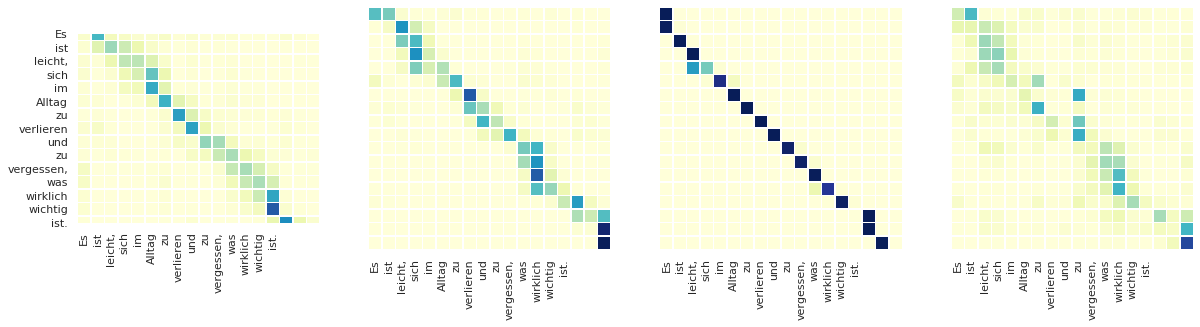

In [63]:
#@title Encoder attention { run: "auto" }
encoder_layer = "1" #@param [1, 3, 5]
fig, axs = plt.subplots(1,4, figsize=(20, 10))
for h in range(4): draw(
    model.encoder.layers[int(encoder_layer)].self_attn.attn[0, h].data.cpu(),
    sent, sent if h ==0 else [], ax=axs[h])
plt.show()

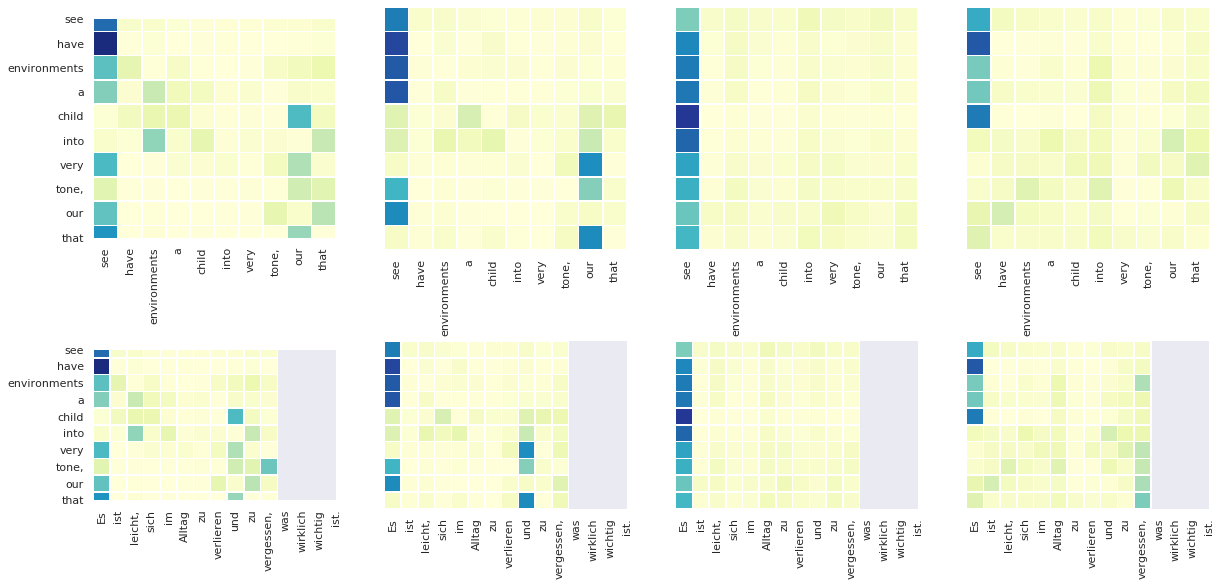

In [64]:
#@title Decoder Attention {run: "auto"}
decoder_layer = "1" #@param [1, 3, 5]
layer = int(decoder_layer)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
attn = model.decoder.layers[layer].self_attn.attn
for h in range(4): 
  l = attn[0, h].data[:len(tgt_sent), :len(tgt_sent)].cpu()
  draw(l, tgt_sent, tgt_sent if h ==0 else [], ax=axs[0,h])
for h in range(4): 
  l = attn[0, h].data[:len(tgt_sent), :len(sent)].cpu()
  draw(l, sent, tgt_sent if h ==0 else [], ax=axs[1, h])
plt.show()
